# Student Performance Prediction Model
## Analysis of Academic Success Factors Using Neural Networks

This project implements a deep learning model to analyze and predict student academic performance based on various lifestyle and environmental factors. The model processes both categorical and continuous variables to understand their impact on exam scores, providing insights for educational support strategies.

The analysis includes:
- Data preprocessing and feature engineering
- Neural network model implementation
- Interactive prediction interface
- Comprehensive visualization of results
- SHAP analysis for feature importance

### Importing Required Libraries and Dependencies


In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from shap import Explanation
from torch.optim import Adam
import warnings
import math

from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display

from tabulate import tabulate

import lightning as L
from lightning.pytorch.callbacks import EarlyStopping
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
from sklearn.model_selection import train_test_split
import shap

#constants

CATEGORICAL_FEATURES = ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation', 'exercise_frequency']
CONTINUOUS_FEATURES = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
                       'attendance_percentage', 'sleep_hours', 'mental_health_rating']

warnings.filterwarnings("ignore", message="The '.*_dataloader' does not have many workers.*")
warnings.filterwarnings("ignore", message="The number of training batches.*log_every_n_steps.*")
warnings.filterwarnings("ignore", message="Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.")



In this section, we'll define our feedforward neural network architecture using PyTorch Lightning. The model consists of three linear layers with ReLU activation functions and dropout regularization to prevent overfitting. The architecture is designed to process both categorical and continuous input features and predict exam scores.


In [3]:
class MultiInputSingleOutputModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.training_losses = []
        self.validation_losses = []
        
        self.linear1 = nn.Linear(14, 32)
        self.dropout1 = nn.Dropout(0.15)

        self.linear2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(0.15)

        self.linear3 = nn.Linear(16, 1)
        self.loss = nn.MSELoss()

    def forward(self, input):
        x = F.relu(self.linear1(input))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.005)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, labels)
        self.training_losses.append(loss.item())
        # self.log('train_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, labels)
        self.log('test_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.validation_losses.append(loss.item())
        self.log('val_loss', loss, prog_bar=True)  # this must match monitor='val_loss'
        return loss



## Feature Engineering for Non-Numerical Data

In this section, we'll prepare our categorical data for model processing by implementing factorization. For each non-numerical input, we'll convert categorical values into numerical representations and display their mappings in a tabulated format. We refer to this as "factorizing". This transformation is essential for neural network processing while maintaining the interpretability of our features.


In [4]:
def tabulate_column_uniques(column: pd.Series):
    unique_vals, encoded_vals = pd.factorize(column)
    table_data = [[i, val] for i, val in enumerate(encoded_vals)]
    friendly_names = {
        "gender": "Gender",
        "part_time_job": "Part-time Job",
        "diet_quality": "Diet Quality",
        "parental_education_level": "Parental Education Level",
        "internet_quality": "Internet Quality",
        "extracurricular_participation": "Extracurricular Participation"
    }
    print(tabulate(table_data, headers=['Value', friendly_names[column.name]], tablefmt="psql"), end='\n')

def print_all_tabulated_columns(df: pd.DataFrame):
    for column in ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']:
        tabulate_column_uniques(input_values[column])

def factorize_columns(df: pd.DataFrame):
    df_copy = df.copy()
    for column in ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']:
        df_copy[column] = df_copy[column].factorize()[0].astype('float32')
    return df_copy


We can now import our data and use these functions to get an idea of what our data looks like. For the sake of presentation and consistency between runs, we'll also seed everything with a hard-coded value.

In [5]:
df = pd.read_csv('./data/student_habits_performance.csv', na_values=[''], keep_default_na=False)
L.seed_everything(6)

input_values = df[['age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage',
                   'sleep_hours', 'diet_quality','exercise_frequency', 'parental_education_level', 'internet_quality',
                   'mental_health_rating', 'extracurricular_participation']]

label_values = df['exam_score'] #observed values

Seed set to 6


Now that the data is imported, let's view what values will represent our non-numerical data

In [6]:
print_all_tabulated_columns(input_values)

+---------+----------+
|   Value | Gender   |
|---------+----------|
|       0 | Female   |
|       1 | Male     |
|       2 | Other    |
+---------+----------+
+---------+-----------------+
|   Value | Part-time Job   |
|---------+-----------------|
|       0 | No              |
|       1 | Yes             |
+---------+-----------------+
+---------+----------------+
|   Value | Diet Quality   |
|---------+----------------|
|       0 | Fair           |
|       1 | Good           |
|       2 | Poor           |
+---------+----------------+
+---------+----------------------------+
|   Value | Parental Education Level   |
|---------+----------------------------|
|       0 | Master                     |
|       1 | High School                |
|       2 | Bachelor                   |
|       3 | None                       |
+---------+----------------------------+
+---------+--------------------+
|   Value | Internet Quality   |
|---------+--------------------|
|       0 | Average          

We can also get an idea of what the overall data looks like

In [7]:
print(tabulate(input_values.head(), headers='keys', tablefmt='psql', showindex='never'))

+-------+----------+-----------------------+----------------------+-----------------+-----------------+-------------------------+---------------+----------------+----------------------+----------------------------+--------------------+------------------------+---------------------------------+
|   age | gender   |   study_hours_per_day |   social_media_hours |   netflix_hours | part_time_job   |   attendance_percentage |   sleep_hours | diet_quality   |   exercise_frequency | parental_education_level   | internet_quality   |   mental_health_rating | extracurricular_participation   |
|-------+----------+-----------------------+----------------------+-----------------+-----------------+-------------------------+---------------+----------------+----------------------+----------------------------+--------------------+------------------------+---------------------------------|
|    23 | Female   |                   0   |                  1.2 |             1.1 | No              |            

And now after factorizing

In [8]:
X = factorize_columns(input_values)
print(tabulate(X.head(), headers='keys', tablefmt='psql', showindex='never'))

+-------+----------+-----------------------+----------------------+-----------------+-----------------+-------------------------+---------------+----------------+----------------------+----------------------------+--------------------+------------------------+---------------------------------+
|   age |   gender |   study_hours_per_day |   social_media_hours |   netflix_hours |   part_time_job |   attendance_percentage |   sleep_hours |   diet_quality |   exercise_frequency |   parental_education_level |   internet_quality |   mental_health_rating |   extracurricular_participation |
|-------+----------+-----------------------+----------------------+-----------------+-----------------+-------------------------+---------------+----------------+----------------------+----------------------------+--------------------+------------------------+---------------------------------|
|    23 |        0 |                   0   |                  1.2 |             1.1 |               0 |            

## Feature Scaling
### Standardizing Continuous Variables

To ensure optimal model performance, we standardize our continuous features using StandardScaler. This transformation centers the data around zero and scales it to unit variance, which is crucial for neural network training.


In [9]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[CONTINUOUS_FEATURES] = scaler.fit_transform(X[CONTINUOUS_FEATURES])
scaled_input = pd.DataFrame(X_scaled, columns=input_values.columns)

## Dataset Preparation
### Train-Test-Validation Split

We divide our dataset into three subsets:
- Training Set (67.5%): Used to train the model
- Validation Set (7.5%): Used for monitoring training and preventing overfitting
- Test Set (25%): Reserved for final model evaluation

Each subset is converted to PyTorch tensors and organized into DataLoader objects for efficient batch processing.

In [10]:
input_train, input_test, label_train, label_test = train_test_split(scaled_input, label_values, test_size=0.25) #splitting the data into train and test sets
input_train, input_val, label_train, label_val = train_test_split(input_train, label_train, test_size=0.1)

input_train_tensors = torch.tensor(input_train.values, dtype=torch.float32) #Converting input train data into tensors. We use .values since torch.tensor() doesn't like DataFrames
input_test_tensors = torch.tensor(input_test.values, dtype=torch.float32) #converting input test data into tensors
input_val_tensors = torch.tensor(input_val.values, dtype=torch.float32) #converting input validation data into tensors

label_train_tensors = torch.tensor(label_train.values, dtype=torch.float32).view(-1, 1)
label_test_tensors = torch.tensor(label_test.values, dtype=torch.float32).view(-1, 1)
label_val_tensors = torch.tensor(label_val.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(input_train_tensors, label_train_tensors) #converting input train data and labels into a dataset
train_dataloader = DataLoader(train_dataset, batch_size=16) #we convert to a DataLoader to make it easier to iterate over batches

test_dataset = TensorDataset(input_test_tensors, label_test_tensors) #same as above, but for test data
test_dataloader = DataLoader(test_dataset, batch_size=16)

validation_dataset = TensorDataset(input_val_tensors, label_val_tensors)
validation_dataloader = DataLoader(validation_dataset, batch_size=8)

## Model Training
### Training Configuration and Early Stopping

We implement early stopping to prevent overfitting and optimize training efficiency. The model will stop training if the validation loss doesn't improve significantly over 10 epochs, using a minimum delta of 1e-4 for improvement detection.


In [11]:
model = MultiInputSingleOutputModel()

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    min_delta=1e-4
)

With the model created and parameters set, we can now train and test the model.

In [12]:
trainer = L.Trainer(max_epochs=100, callbacks=[early_stop], gradient_clip_val=0.5, enable_progress_bar=False) 
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

test_results = trainer.test(model, dataloaders=test_dataloader)
test_loss = math.sqrt(test_results[0]['test_loss'])

print(f"Test Loss: {test_loss:.2f}")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type    | Params | Mode 
---------------------------------------------
0 | linear1  | Linear  | 480    | train
1 | dropout1 | Dropout | 0      | train
2 | linear2  | Linear  | 528    | train
3 | dropout2 | Dropout | 0      | train
4 | linear3  | Linear  | 17     | train
5 | loss     | MSELoss | 0      | train
---------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     24.82941436767578     │
└───────────────────────────┴───────────────────────────┘

Test Loss: 4.98


After training, we can see that our test data returns a value of 24.8294~. Our loss function utilized was Mean Squared Error (MSELoss()), so to interpret these results we can convert the Mean Squared Error to the Root Mean Squared Error (RMSE) by taking the square root of our test_loss value, which gives us a value represented in units as our expected Exam Scores. This RMSE of approximately 4.98 means that, on average, your model's predictions deviate from the actual exam scores by about 5 points. For example, if the actual exam score was 85, our Model might predict anywhere from roughly 80 to 90 (±5 points).


### Feature Importance Analysis
Using SHAP (SHapley Additive exPlanations) values to interpret our model's predictions and understand the impact of each feature on exam performance.

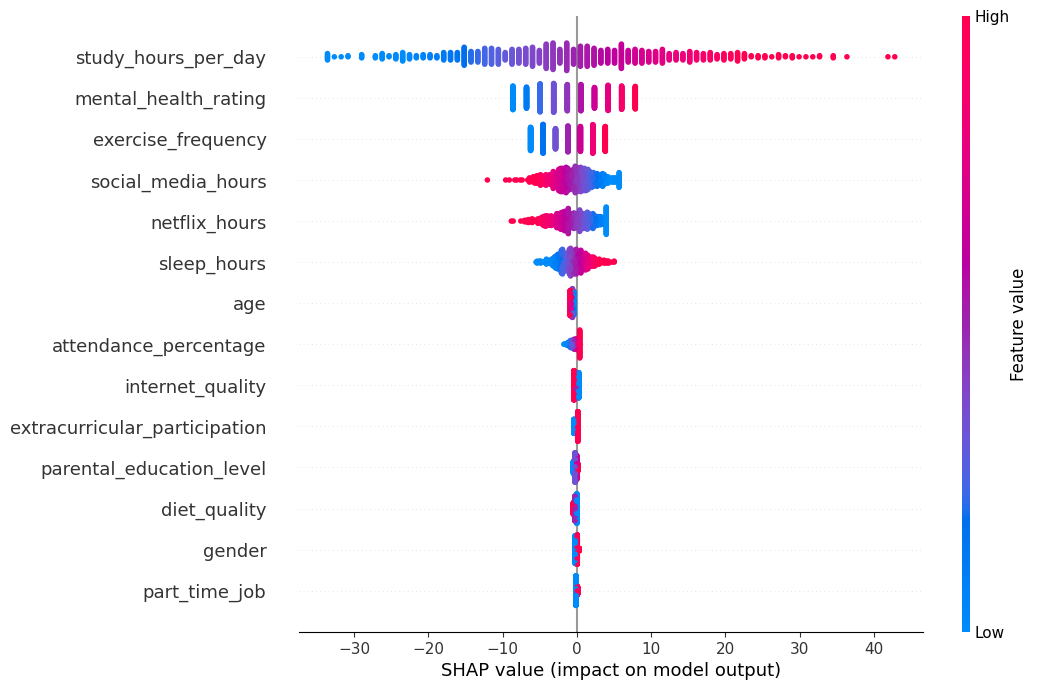

In [13]:
explainer = shap.DeepExplainer(model, input_train_tensors)

explanation = explainer.shap_values(input_train_tensors, check_additivity=False).squeeze()


shap_explanation = Explanation(explanation,
                             feature_names=input_values.columns,
                             data=input_train_tensors.numpy())  # Add the background data
shap.plots.beeswarm(shap_explanation,
                    max_display=14,  # Show all features
                    plot_size=(12,8),
                    show=False)
plt.subplots_adjust(left=0.25)  # Increase left margin for labels
plt.show()

#### Understanding Feature Impacts through SHAP Analysis

The SHAP (SHapley Additive exPlanations) analysis reveals several key insights about our model:

1. **Primary Positive Factors**:
   - Study hours per day
   - Mental health rating
   - Exercise frequency
   - Attendance percentage

2. **Primary Negative Factors**:
   - Excessive social media usage
   - Extended Netflix viewing hours

This analysis helps identify which factors have the most significant impact on academic performance and in what direction.


We'll also create a graph that displays Training and Validation Loss over time

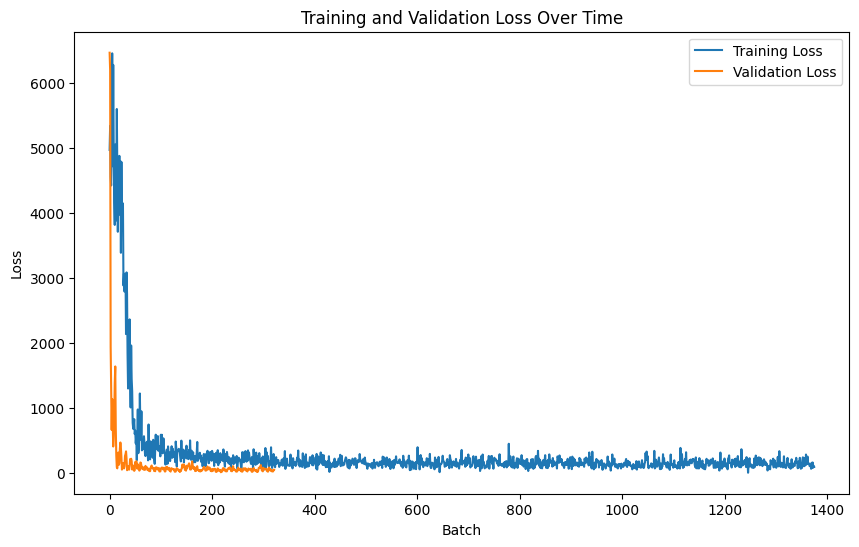

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(model.training_losses, label='Training Loss')
plt.plot(model.validation_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

The Training and Validation Loss graph provides insight into our model's learning process over time. As the model trained through multiple epochs, both the training and validation loss curves showed consistent improvement by decreasing steadily. The close alignment between these curves is particularly important, as it indicates the model learned effectively from the training data while maintaining its ability to generalize to new, unseen data. This behavior suggests we've achieved a well-balanced model that neither overfits nor underfits the data.

Finally, we'll create a scatter plot to visualize our Model's predicted Exam scores versus the dataset's actual exam scores.

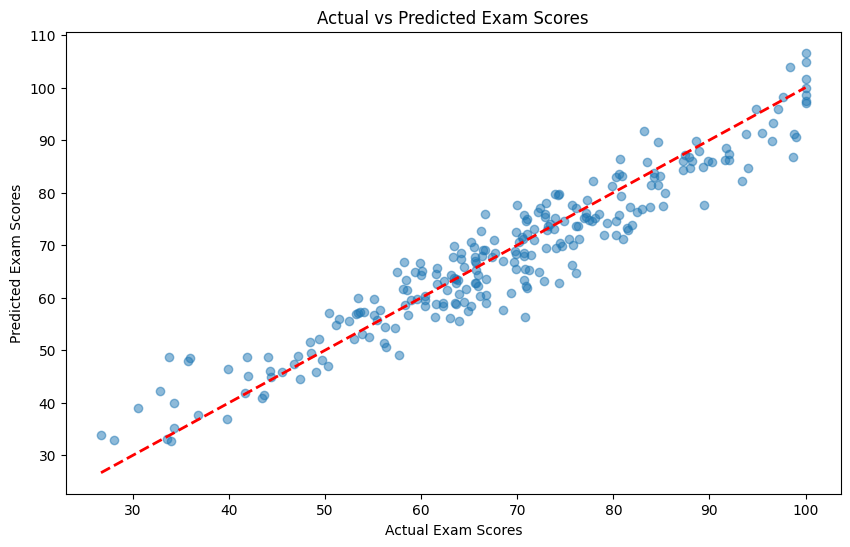

In [15]:
model.eval()
with torch.no_grad():
    predictions = model(input_test_tensors).numpy()

plt.figure(figsize=(10, 6))
plt.scatter(label_test_tensors.numpy(), predictions, alpha=0.5)
plt.plot([label_test_tensors.min(), label_test_tensors.max()],
         [label_test_tensors.min(), label_test_tensors.max()],
         'r--', lw=2)
plt.xlabel('Actual Exam Scores')
plt.ylabel('Predicted Exam Scores')
plt.title('Actual vs Predicted Exam Scores')
plt.show()

The Actual vs Predicted Exam Scores scatter plot demonstrates the model's prediction accuracy through a direct comparison of predicted scores against actual results. Points clustered along the diagonal red line represent accurate predictions, where predicted scores closely match actual scores. While some scatter exists around this line, indicating prediction variations, the overall strong diagonal pattern confirms the model's reliability. The distribution is particularly dense in the middle range of scores, suggesting the model excels at predicting average student performance, though it maintains reasonable accuracy across the full range of scores.

## Interactive Model Testing
### Real-time Exam Score Prediction

This section provides an interactive interface to test the trained model with custom input values. Users can:
- Adjust various student characteristics using sliders and dropdown menus
- See immediate predictions based on the selected values
- Experiment with different combinations of factors to understand their impact on exam performance

The prediction tool helps demonstrate the practical application of our model and its potential use in real-world scenarios.

In [16]:
def initialize_sliders():
    sliders = {
        'age': widgets.IntSlider(description='Age', min=17, max=24, value=20),
        'gender': widgets.Dropdown(description='Gender', options=['Male', 'Female', 'Other'], value='Male'),
        'study_hours_per_day': widgets.FloatSlider(description='Study Hours', min=0, max=8.3, step=0.1, value=2.5),
        'social_media_hours': widgets.FloatSlider(description='Social Media Hours', min=0, max=6.2, step=0.1, value=0.0),
        'netflix_hours': widgets.FloatSlider(description='Netflix Hours', min=0, max=5.5, step=0.1, value=0.0),
        'part_time_job': widgets.Dropdown(description='Part-time Job', options=['Yes', 'No'], value='No'),
        'attendance_percentage': widgets.FloatSlider(description='Attendance Percentage', min=56, max=100, step=0.1, value=84.0),
        'sleep_hours': widgets.FloatSlider(description='Sleep Hours', min=3.5, max=10, step=0.5, value=7.0),
        'diet_quality': widgets.Dropdown(description='Diet Quality', options=['Poor', 'Fair', 'Good'], value='Fair'),
        'exercise_frequency': widgets.IntSlider(description='Exercise Frequency', min=0, max=7, step=1, value=0),
        'parental_education_level': widgets.Dropdown(description='Parental Education Level', options=['None', 'High School', 'Bachelor', 'Master'], value='None'),
        'internet_quality': widgets.Dropdown(description='Internet Quality', options=['Poor', 'Average', 'Good'], value='Average'),
        'mental_health_rating': widgets.IntSlider(description='Mental Health Rating', min=1, max=10, step=1, value=5),
        'extracurricular_participation': widgets.Dropdown(description='Extracurricular Participation', options=['Yes', 'No'], value='No')
    }

    predict_button = widgets.Button(description='Predict Exam Score')
    output = widgets.Output()

    def on_button_click(b):
        with output:
            output.clear_output()
            # Gather all values into a dictionary
            values = {name: widget.value for name, widget in sliders.items()}

            # Convert to DataFrame
            input_df = pd.DataFrame([values])

            # Apply the same preprocessing as training data
            X = factorize_columns(input_df)
            X[CONTINUOUS_FEATURES] = scaler.transform(X[CONTINUOUS_FEATURES])

            # Convert to tensor and get prediction
            input_tensor = torch.tensor(X.values, dtype=torch.float32)

            model.eval()
            with torch.no_grad():
                prediction = model(input_tensor)
                clamped_prediction = prediction.clamp(min=0.0, max=100.0)
                print(f"Predicted Exam Score: {clamped_prediction.item():.2f}")

    predict_button.on_click(on_button_click)

    for widget in sliders.values():
        display(widget)
    display(predict_button)
    display(output)

    return sliders


In [17]:
sliders = initialize_sliders()

IntSlider(value=20, description='Age', max=24, min=17)

Dropdown(description='Gender', options=('Male', 'Female', 'Other'), value='Male')

FloatSlider(value=2.5, description='Study Hours', max=8.3)

FloatSlider(value=0.0, description='Social Media Hours', max=6.2)

FloatSlider(value=0.0, description='Netflix Hours', max=5.5)

Dropdown(description='Part-time Job', index=1, options=('Yes', 'No'), value='No')

FloatSlider(value=84.0, description='Attendance Percentage', min=56.0)

FloatSlider(value=7.0, description='Sleep Hours', max=10.0, min=3.5, step=0.5)

Dropdown(description='Diet Quality', index=1, options=('Poor', 'Fair', 'Good'), value='Fair')

IntSlider(value=0, description='Exercise Frequency', max=7)

Dropdown(description='Parental Education Level', options=('None', 'High School', 'Bachelor', 'Master'), value=…

Dropdown(description='Internet Quality', index=1, options=('Poor', 'Average', 'Good'), value='Average')

IntSlider(value=5, description='Mental Health Rating', max=10, min=1)

Dropdown(description='Extracurricular Participation', index=1, options=('Yes', 'No'), value='No')

Button(description='Predict Exam Score', style=ButtonStyle())

Output()

## Conclusions and Applications
### Key Findings and Practical Implementation

Our neural network model successfully identifies and quantifies the relationships between student lifestyle factors and academic performance. The results suggest:

1. **Time Management Importance**:
   - Study hours show the strongest positive correlation
   - Entertainment activities (social media, streaming) show negative impacts

2. **Health Factors**:
   - Mental health significantly influences performance
   - Physical exercise contributes positively
   - Adequate sleep shows moderate positive impact

3. **Educational Environment**:
   - Attendance remains a crucial factor
   - Internet quality affects learning outcomes
   - Extracurricular activities show positive correlation

These findings can be applied to develop targeted interventions and support strategies for improving student performance.
